# Exploring some of the limitations of decision trees

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---
Here we explore some of the limitations of decision trees as outlined in the lecture.

For more information, see the [lecture slides on decision trees and ensemble methods](https://loop.dcu.ie/mod/resource/view.php?id=659547), slide 26 to 33. Also see [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf), Section 9.2.4: Other Issues.

## Setup

In [ ]:
%pylab inline

In [ ]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_circles

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

## Define some utility functions

These are some auxillary functions that will be used in the next few colab notebooks.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib as mpl


mpl.rcParams['figure.figsize'] = (8,6)
sns.set_style('white')


def load_dataset(fn):
    data = np.load(fn)
    return data['X'], data['y']


def plot_dataset(X, y, save=None, pos=1, neg=-1):
    figure(figsize=(8,6))
    positives = X[y==pos]
    negatives = X[y==neg]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend(frameon=True)
    if save:
        savefig(save)
    show()


def scatter_dataset(X, y, palette='Accent'):
    classes = np.unique(y)
    colors = sns.color_palette(palette, len(classes))
    for cls, color in zip(classes, colors):
        values = X[y==cls]
        scatter(values[:, 0], values[:, 1], s=100, c=color, label=cls, edgecolor='k')
    xlabel('$x_1$')
    ylabel('$x_2$')
    legend(frameon=True)


def generate_meshgrid_for_data(X, y):

    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min

    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range

    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)

    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    return X0, X1


def fill_decision_function(df, X, y, **kwargs):

    # Generate meshgrid
    X0, X1 = generate_meshgrid_for_data(X, y)

    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    save = kwargs.pop('save', False)

    # Plot the decision function
    figure(figsize=(8,6))
    contourf(X0, X1, Y, **kwargs)
    scatter_dataset(X, y)
    if save:
        savefig(save)


def plot_decision_function(df, X, y, save=None, levels=(-1,0,1)):

    # Generate meshgrid
    X0, X1 = generate_meshgrid_for_data(X, y)

    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)

    # Plot the decision function
    figure(figsize=(8,6))
    contour(X0, X1, Y, levels=levels,
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')

    scatter_dataset(X, y)
    if save:
        savefig(save)
    show()


## Limitation: difficulty breaking symmetry

Here we construct a pathological example where the symmetry means that the cost of all possible split points is the same for the first split.

In [ ]:
def make_symmetric_data(r=3):
    angles = np.deg2rad([45, 135, 225, 315])
    x1 = r * np.sin(angles)
    x2 = r * np.cos(angles)
    x1 = np.concatenate([x1 - 1, x1 - 1, x1 + 1, x1 + 1])
    x2 = np.concatenate([x2 - 1, x2 + 1, x2 - 1, x2 + 1])
    y = np.tile([1,2,1,2], 4)
    X = np.c_[x1, x2]
    return X, y

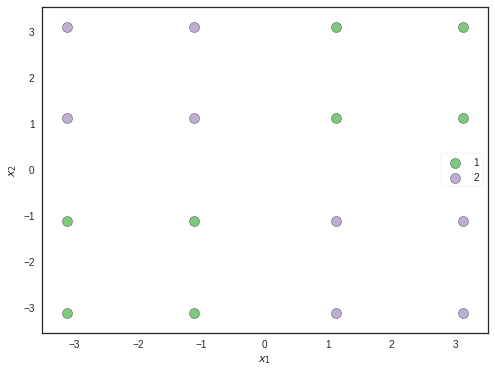

In [ ]:
X, y = make_symmetric_data()
scatter_dataset(X, y)

Observe that no matter where we place an axis aligned split, the proportion of objects of each class in the resulting nodes is equal. Therefore, all splits have the same cost, and it is not easy to choose between them.


Libraries like scikit-learn implement a reasonable *heuristic* solution to cases like these: just choose the in which the number of elements in each subnode is close to equal. This small modification means that the algorithm can break the symmetry and arrive at a good solution.

The  is also a good example of why rules to stop splitting if impurity reduction is too small are shortsighted.


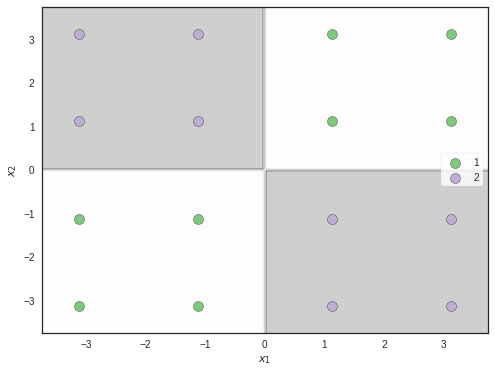

In [ ]:
clf = DecisionTreeClassifier().fit(X, y)
fill_decision_function(clf.predict, X, y, alpha=0.2)

## Limitation: difficulty producing smooth/simple decision boundaries

Because decision trees can only produce axis aligned splits, they cannot produce smooth decision boundaries like some other classes of non-linear classifiers (e.g. Kernel SVMs). 

Here we consider two examples: one simple synthetic dataset of concentric circles and another more realistic example.

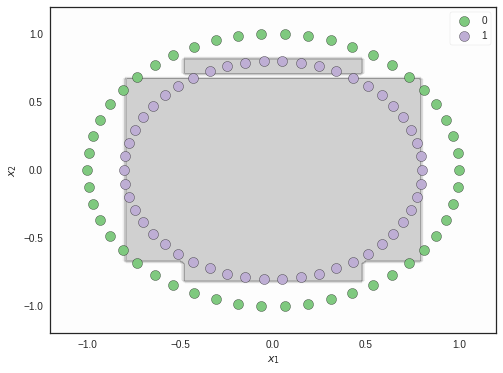

In [ ]:
X, y = make_circles(random_state=32)
clf = DecisionTreeClassifier().fit(X, y)
fill_decision_function(clf.predict, X, y, alpha=0.2)

Here's an example on a more realistic dataset.

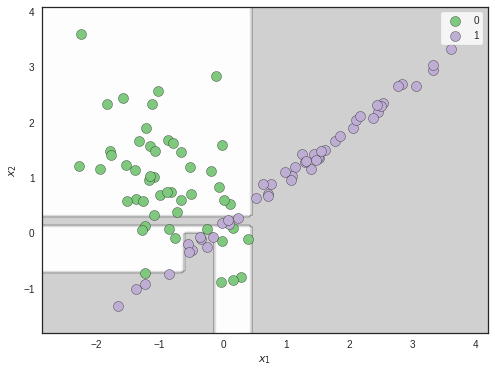

In [ ]:
np.random.seed(9)
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1)
clf = DecisionTreeClassifier().fit(X, y)
fill_decision_function(clf.predict, X, y, alpha=0.2)

The resulting decision boundary is complex and has several undesirable properties.

You can try to remedy this by limiting the depth of the tree, but the results are still somewhat unsatisfying.

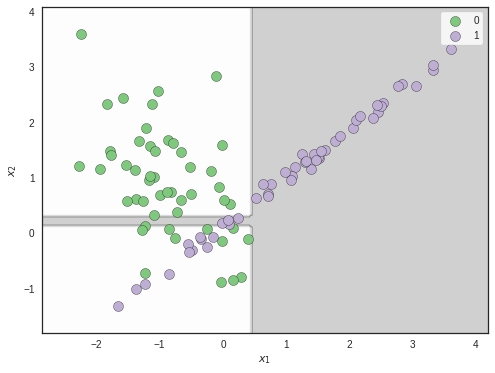

In [ ]:
clf = DecisionTreeClassifier(max_depth=3).fit(X, y)
fill_decision_function(clf.predict, X, y, alpha=0.2)

## Limitation: difficulty in capturing additive structure

Decision trees have difficulty in capturing *additive structrure*.

Suppose that:

$$y = c_1 \mathbb{1}(X_1 < t_1) + c_2\mathbb{1}(X_2 < t_2) + \epsilon$$

Then the tree needs 1 split to represent $\mathbb{1}(X_1 < t_1)$. However, it now needs two splits to capture $\mathbb{1}(X_2 < t_2)$, one at each of the nodes generated by the first split. This pattern continues, with the $N^{\text{th}}$ additive term needing $2^{N-1}$ splits.

In [ ]:
def make_additive_data(n=100, c1=10, c2=3, t1=0.3, t2=0.7, eps=0.0):
    X = np.random.rand(n, 2)
    noise = np.random.randn(n) * eps
    y = c1 * (X[:,0] < t1) + c2 * (X[:,1] < t2) + noise
    return X, y

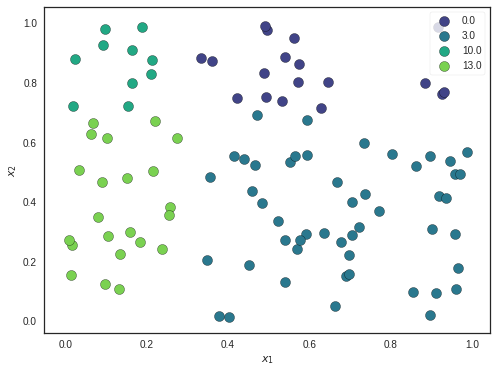

In [ ]:
np.random.seed(191919)
X, y = make_additive_data()
scatter_dataset(X, y, palette='viridis')
xlabel('$x_1$')
ylabel('$x_2$')
show()

The function to be modelled is piecewise constant, and we have used color to represent the function value at the training examples in the above.

Below we fit a decision tree regressor.

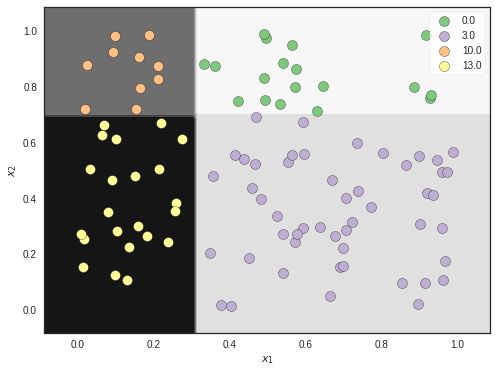

In [ ]:
r = DecisionTreeRegressor().fit(X, y)
fill_decision_function(r.predict, X, y)

The decision tree appears to model the function very nicely! However, it needs 3 splits to do this. 

Below we use graphviz to visualize the resulting graph. Graphviz is not installed by default, so we install it here.

In [ ]:
!apt-get -qq install graphviz

Then we use sklearn's `export_graphviz` function to generate a `dot` file.

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(r, out_file='tree.dot')

and use the graphviz `dot` command to render it as a PNG image

In [ ]:
!dot -Tpng tree.dot -o tree.png   

And finally, we use the IPython Image cass to display the result in the notebook

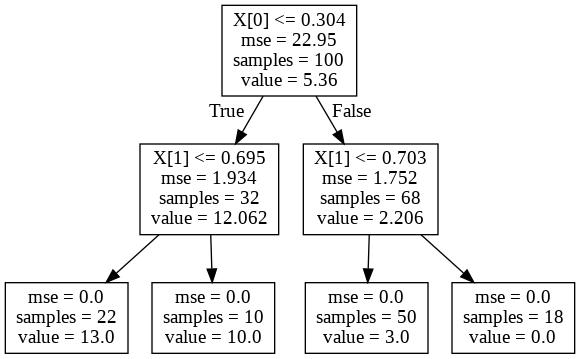

In [ ]:
from IPython.display import Image, display

display(Image('tree.png'))

3 splits doesn't seem too bad until you realize that the total number of splits needed to represent $N$ additive terms is $$ \sum_{n=0}^{N-1} 2^{n}.$$ For example, if $N$ is 10 we need:

In [ ]:
sum(2**n for n in range(10))

1023

And if $N$ is 50 we need

In [ ]:
sum(2**n for n in range(50))

1125899906842623